# Analyzing Tune Experiment Results

In this guide, we'll walk through some common workflows of what analysis you might want to perform after running your Tune experiment with `tuner.fit()`.

1. Loading Tune experiment results from a directory
2. Basic *experiment-level* analysis: get a quick overview of how trials performed
3. Basic *trial-level* analysis: access individual trial hyperparameter configs and last reported metrics
4. Plotting the entire history of reported metrics for a trial
5. Accessing saved checkpoints (assuming that you have enabled checkpointing) and loading into a model for test inference

```python
result_grid: ResultGrid = tuner.fit()
best_result: Result = result_grid.get_best_result()
```

The output of `tuner.fit()` is a [`ResultGrid`](result-grid-docstring), which is a collection of [`Result`](result-docstring) objects. See the linked documentation references for [`ResultGrid`](result-grid-docstring) and [`Result`](result-docstring) for more details on what attributes are available.

Let's start by performing a hyperparameter search with the MNIST PyTorch example. The training function is defined {doc}`here </tune/examples/includes/mnist_pytorch>`, and we pass it into a `Tuner` to start running the trials in parallel.

In [ ]:
from ray import tune, air
from ray.tune.examples.mnist_pytorch import train_mnist
from ray.tune import ResultGrid

local_dir = "/tmp/ray_results"
exp_name = "tune_analyzing_results"
tuner = tune.Tuner(
    train_mnist,
    param_space={
        "lr": tune.loguniform(0.001, 0.1),
        "momentum": tune.grid_search([0.8, 0.9, 0.99]),
        "should_checkpoint": True,
    },
    run_config=air.RunConfig(
        name=exp_name,
        stop={"training_iteration": 100},
        checkpoint_config=air.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=5,
        ),
        local_dir=local_dir,
    ),
    tune_config=tune.TuneConfig(mode="max", metric="mean_accuracy", num_samples=3),
)
result_grid: ResultGrid = tuner.fit()

## Loading experiment results from an directory

Although we have the `result_grid` object in memory because we just ran the Tune experiment above, we might be performing this analysis after our initial training script has exited. We can retrieve the `ResultGrid` from a [restored `Tuner`](tune-stopping-guide), passing in the experiment directory, which should look something like `~/ray_results/{exp_name}`. If you don't specify an experiment `name` in the `RunConfig`, the experiment name will be auto-generated and can be found in the logs of your experiment.

In [19]:
experiment_path = f"{local_dir}/{exp_name}"
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path)
result_grid = restored_tuner.get_results()

Loading results from /tmp/ray_results/tune_analyzing_results...


2022-10-17 16:04:54,189	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


## Experiment-level Analysis: Working with `ResultGrid`

The first thing we might want to check is if there were any erroring trials.

In [3]:
# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

No errors!


Note that `ResultGrid` is an iterable, and we can access its length and index into it to access individual `Result` objects.

We should have **9** results in this example, since we have 3 samples for each of the 3 grid search values.

In [4]:
num_results = len(result_grid)
print("Number of results:", num_results)

Number of results: 9


In [5]:
# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a mean accuracy metric of:",
        result.metrics["mean_accuracy"]
    )

Trial #0 finished successfully with a mean accuracy metric of: 0.96875
Trial #1 finished successfully with a mean accuracy metric of: 0.925
Trial #2 finished successfully with a mean accuracy metric of: 0.946875
Trial #3 finished successfully with a mean accuracy metric of: 0.86875
Trial #4 finished successfully with a mean accuracy metric of: 0.94375
Trial #5 finished successfully with a mean accuracy metric of: 0.971875
Trial #6 finished successfully with a mean accuracy metric of: 0.91875
Trial #7 finished successfully with a mean accuracy metric of: 0.965625
Trial #8 finished successfully with a mean accuracy metric of: 0.740625


Above, we printed the **last reported** `mean_accuracy` metric for all trials by looping through the `result_grid`.
We can access the same metrics for all trials in a pandas DataFrame.

In [6]:
results_df = result_grid.get_dataframe()
results_df[["training_iteration", "mean_accuracy"]]

,training_iteration,mean_accuracy
0,100,0.968750
1,100,0.925000
2,100,0.946875
3,100,0.868750
4,100,0.943750
5,100,0.971875
6,100,0.918750
7,100,0.965625
8,100,0.740625


In [7]:
print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

Shortest training time: 28.826712369918823
Longest training time: 31.22410249710083


The last reported metrics might not contain the best accuracy each trial achieved. If we want to get maximum accuracy that each trial reported throughout its training, we can do so by using {meth}`ResultGrid.get_dataframe <ray.tune.result_grid.ResultGrid.get_dataframe>` specifying a metric and mode used to filter each trial's training history.

In [8]:
best_result_df = result_grid.get_dataframe(
    filter_metric="mean_accuracy", filter_mode="max"
)
best_result_df[["training_iteration", "mean_accuracy"]]

,training_iteration,mean_accuracy
0,81,0.978125
1,44,0.953125
2,96,0.953125
3,94,0.925000
4,87,0.975000
5,92,0.978125
6,77,0.959375
7,59,0.971875
8,10,0.896875


## Trial-level Analysis: Working with an individual `Result`

Let's take a look at the result that ended with the best `mean_accuracy` metric. By default, `get_best_result` will use the same metric and mode as defined in the `TuneConfig` above. However, it's also possible to specify a new metric/order in which results should be ranked.

In [9]:
from ray.air import Result

# Get the result with the maximum test set `mean_accuracy`
best_result: Result = result_grid.get_best_result()

# Get the result with the minimum `mean_accuracy`
worst_performing_result: Result = result_grid.get_best_result(
    metric="mean_accuracy", mode="min"
)

We can examine a few of the properties of the best `Result`. See the [API reference](result-docstring) for a list of all accessible properties.

First, we can access the best result's hyperparameter configuration with `Result.config`.

In [10]:
best_result.config

{'lr': 0.0034759400828981743, 'momentum': 0.99, 'should_checkpoint': True}

Next, we can access the trial's log directory via `Result.log_dir`. The result `log_dir` gives the trial level directory that contains checkpoints (if you had checkpointing enabled) and logged metrics to load manually or inspect using a tool like Tensorboard (see `result.json`, `progress.csv`).

In [11]:
best_result.log_dir

PosixPath('/tmp/ray_results/tune_analyzing_results/train_mnist_daaa1_00005_5_lr=0.0035,momentum=0.9900_2022-10-17_16-03-12')

You can also directly get the latest checkpoint for a specific trial via `Result.checkpoint`.

In [12]:
# Get the last Ray AIR Checkpoint associated with the best-performing trial
best_result.checkpoint

TorchCheckpoint(local_path=/tmp/ray_results/tune_analyzing_results/train_mnist_daaa1_00005_5_lr=0.0035,momentum=0.9900_2022-10-17_16-03-12/checkpoint_000099)

You can also get the last-reported metrics associated with a specific trial via `Result.metrics`.

In [13]:
# Get the last reported set of metrics
best_result.metrics

{'mean_accuracy': 0.971875,
 'time_this_iter_s': 0.23050832748413086,
 'should_checkpoint': True,
 'done': True,
 'timesteps_total': None,
 'episodes_total': None,
 'training_iteration': 100,
 'trial_id': 'daaa1_00005',
 'experiment_id': 'a15f57f8a3f84b1d823c2cf65c37aece',
 'date': '2022-10-17_16-03-45',
 'timestamp': 1666047825,
 'time_total_s': 29.587023496627808,
 'pid': 3699,
 'hostname': 'ip-172-31-113-120',
 'node_ip': '172.31.113.120',
 'config': {'lr': 0.0034759400828981743,
  'momentum': 0.99,
  'should_checkpoint': True},
 'time_since_restore': 29.587023496627808,
 'timesteps_since_restore': 0,
 'iterations_since_restore': 100,
 'warmup_time': 0.003263711929321289,
 'experiment_tag': '5_lr=0.0035,momentum=0.9900'}

Access the entire history of reported metrics from a `Result` as a pandas DataFrame:

In [14]:
result_df = best_result.metrics_dataframe
result_df[["training_iteration", "mean_accuracy", "time_total_s"]]

,training_iteration,mean_accuracy,time_total_s
0,1,0.121875,1.874643
1,2,0.340625,2.110028
2,3,0.321875,2.332039
3,4,0.521875,2.621943
4,5,0.684375,2.958664
...,...,...,...
95,96,0.953125,28.516581
96,97,0.959375,28.819717
97,98,0.934375,29.085851
98,99,0.968750,29.356515


## Plotting metrics

We can use the metrics DataFrame to quickly visualize learning curves. First, let's plot the mean accuracy vs. training iterations for the best result.

<AxesSubplot: xlabel='training_iteration'>

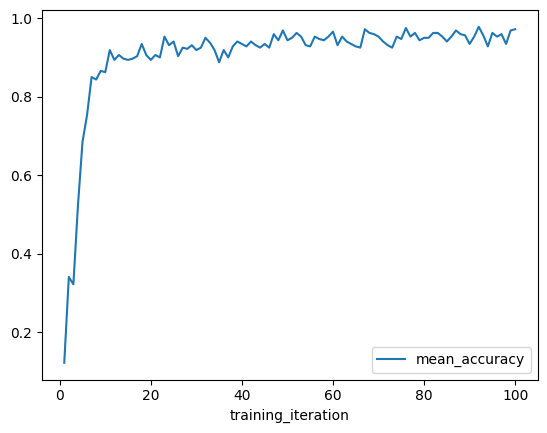

In [15]:
best_result.metrics_dataframe.plot("training_iteration", "mean_accuracy")

We can also iterate through the entire set of results and create a combined plot of all trials with the hyperparameters as labels.

Text(0, 0.5, 'Mean Test Accuracy')

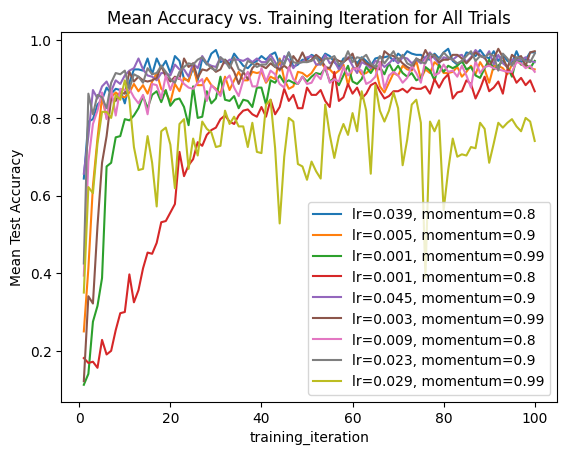

In [16]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.3f}, momentum={result.config['momentum']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "mean_accuracy", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "mean_accuracy", ax=ax, label=label)
ax.set_title("Mean Accuracy vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Accuracy")

## Accessing checkpoints and loading for test inference

We noticed earlier that `Result` contains the last checkpoint associated with a trial. Let's see how we can use this checkpoint to load a model for performing inference on some sample MNIST images.

If you are running a Tune experiment with Ray AIR Trainers, the checkpoints saved may be framework-specific checkpoints such as `TorchCheckpoint`. Refer to [documentation on framework-specific integrations](air-trainer-ref) to learn how to load from these types of checkpoints.

In [17]:
from ray.train.torch import TorchCheckpoint, TorchPredictor
from ray.tune.examples.mnist_pytorch import ConvNet, get_data_loaders

checkpoint: TorchCheckpoint = best_result.checkpoint

# Create a Predictor using the best result's checkpoint
predictor = TorchPredictor.from_checkpoint(checkpoint, ConvNet())

Refer to the training loop definition {doc}`here </tune/examples/includes/mnist_pytorch>` to see how we are saving the checkpoint in the first place.

Next, let's test our model with a sample data point and print out the predicted class.

Predicted Class = 4


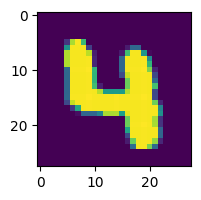

In [18]:
import matplotlib.pyplot as plt
import numpy as np

_, test_loader = get_data_loaders()
test_img = next(iter(test_loader))[0][0]
# Need to reshape to (batch_size, channels, width, height)
test_img = test_img.numpy().reshape((1, 1, 28, 28))
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape((28, 28)))

predicted_class = np.argmax(predictor.predict(test_img))
print("Predicted Class =", predicted_class)

Consider using [Ray AIR batch prediction](air-predictors) if you want to use a checkpointed model for large scale inference!

## Summary

In this guide, we looked at some common analysis workflows you can perform using the `ResultGrid` output returned by `Tuner.fit`. These included: **loading results from an experiment directory, exploring experiment-level and trial-level results, plotting logged metrics, and accessing trial checkpoints for inference.**

Take a look at [Tune's experiment tracking integrations](tune-experiment-tracking-examples) for more analysis tools that you can build into your Tune experiment with a few callbacks!